<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour la prédiction de keypoints</b></font></center>
<br>
<br>
<br>

# Contexte

## Intentions

Prédire des keypoints qui constitueront un parallélépipède autour d'un container avec des images qui ne contiennent qu'un container.

Étant donnée qu'un parallélépipède est défini par 4 points et un sommet, nous n'allons travailler que sur la prédiction de 4 points. Les autres points seront déterminés par reconstruction géométrique via des fonctions.

En attendant le dataset définitif, nous utiliserons le dataset des containers en le filtrant sur des bounding boxes dont l'aire est comprise entre 25 et 75 % de l'image. On limitera aussi les images à un container comme défini lors de notre dernière réunion de projet.

## Papiers de recherches

Papiers de recherche étudiés :

    - BBOX 3D
    https://arxiv.org/pdf/2006.07864.pdf
    https://arxiv.org/pdf/2012.09771.pdf

    - PINNs
    https://arxiv.org/pdf/2201.05624.pdf

# Notebook

## Versions

CV_SEGA_model_keypoints.md

## Configuration du notebook

In [34]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "drive"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [35]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [36]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive')

Nom du notebook :  CV_SEGA_model_keypoints_1_1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installer

In [37]:
if work_mode == "drive":
    !pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Modules et fonctions

## Import des modules


In [38]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json
from glob import glob

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split

## La cuisine

## Test GPU

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.pprint(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

GPU found : /device:GPU:0
OrderedDict([('cpu_compiler', '/usr/bin/x86_64-linux-gnu-gcc-7'),
             ('cuda_compute_capabilities',
              ['compute_37',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75',
               'compute_80']),
             ('cuda_version', '11.1'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False)])


# Chargement du dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        548 non-null    string
 1   bbox_normalized  548 non-null    object
dtypes: object(1), string(1)
memory usage: 8.7+ KB


None

,file_path,bbox_normalized
0,/content/drive/MyDrive/CV_DS/_data/container/0...,"[0.436, 0.42133333333333334, 0.8, 0.5973333333..."
1,/content/drive/MyDrive/CV_DS/_data/container/0...,"[0.4625984251968504, 0.46335078534031415, 0.92..."
2,/content/drive/MyDrive/CV_DS/_data/container/0...,"[0.5670289855072463, 0.5027322404371585, 0.706..."
3,/content/drive/MyDrive/CV_DS/_data/container/0...,"[0.4362934362934363, 0.5335051546391752, 0.733..."
4,/content/drive/MyDrive/CV_DS/_data/container/0...,"[0.4781818181818182, 0.5218579234972678, 0.927..."


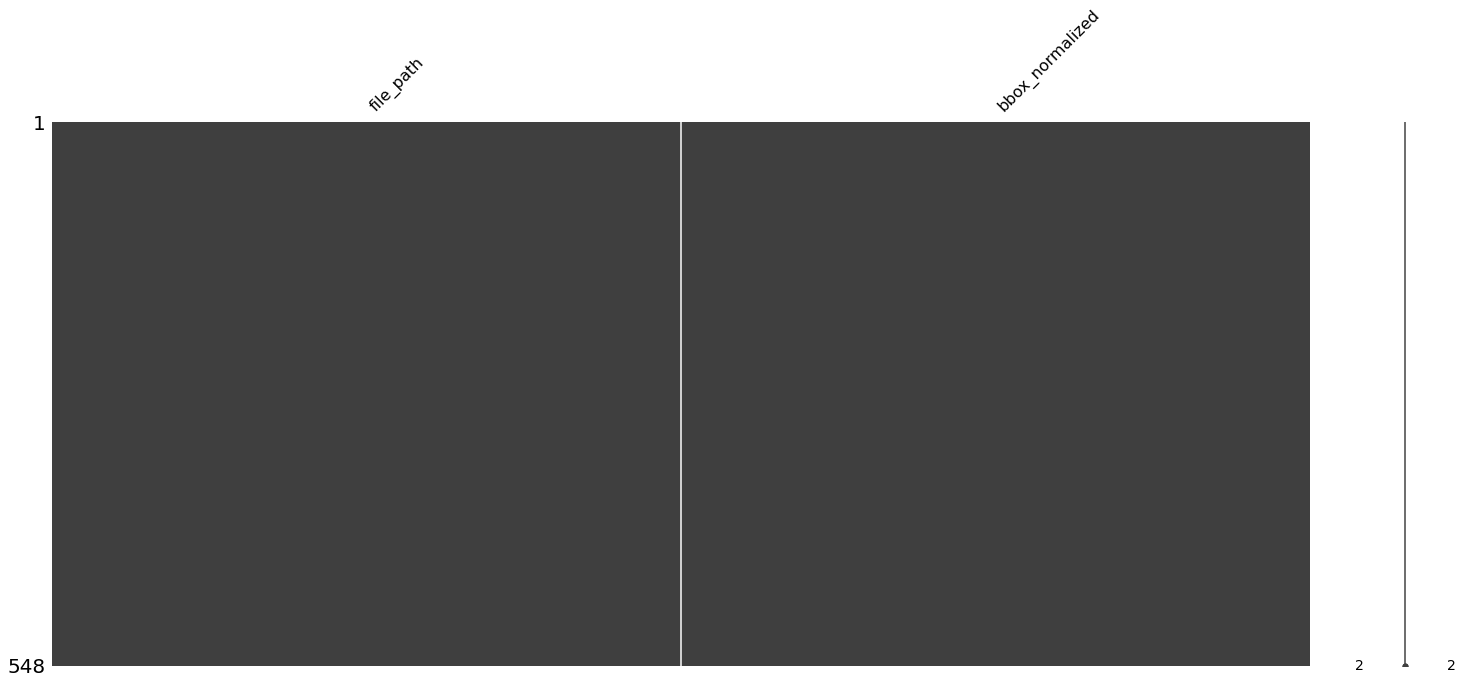

In [41]:
# Lecture des données
if work_mode == "local":
    data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"
#     data_path = "E:/OneDrive/_forge/SEGA/datasets/container"
elif work_mode == "drive":
    data_path = "/content/drive/MyDrive/CV_DS/_data/container"

# Lecture du fichier csv    
df = pd.read_csv(data_path + '/df_1.csv',index_col=0,converters={'bbox': pd.eval})

# Conversion en string de file_name
df = df.astype({'file_name':'string'})

# Construction des chemin des images
df["file_path"] = df["file_name"].apply(lambda x: data_path + "/" + x)

# Récupération des images ne contenant qu'un seul container
df_group = df.groupby("file_name",as_index=False).agg({"file_name":"min",
                                 "file_extension":"count"})
df_group.rename(columns={'file_extension': 'occurence'}, inplace = True)
df_group = df_group[df_group["occurence"]==1]
img_list = df_group["file_name"].tolist()

# Filtrage du dataset principal
df = df[df["file_name"].isin(img_list)]

# Normalisation des BB x_moy, y_moy, w et h
def convertWHXY_normalized(x):
    bbox = x['bbox']
    w = x['width']
    h = x['height']
    return [(bbox[0]+(bbox[2]/2))/w, (bbox[1]+(bbox[3]/2))/h, (bbox[2])/w, bbox[3]/h]
df['bbox_normalized'] = df[["height", "width", "bbox"]].apply(convertWHXY_normalized, axis=1)

# Filtrage des BB dont l'aire est comprise en 25 et 75 % de l'image
df = df[(df["bbox_area"]>=25)&(df["bbox_area"]<=75)]

# Reset index
df.reset_index(drop=True, inplace=True)

# Réduction du nombre de colonnes :
df = df.astype({'file_path':'string'})
df = df[["file_path","bbox_normalized"]]

# Visualisation
display(df.info())
display(df.head())
msno.matrix(df);

# Preprocessing

## Séparation

In [42]:
################ Réalisation des sets d'entrainnement et de tests
"""
    taille du set de test => 10 % des données restantes
    random_state => 42
"""

X_train, X_test, y_train, y_test = train_test_split(df.file_path.to_list(),
                                                    df.bbox_normalized.to_list(),
                                                    train_size=0.9,
                                                    random_state=42)

## Fonctions de chargement set bennes

**Choix des dimensions d'entrée en fonction du modèle :**

    EfficientNetB0 - (224, 224, 3)
    EfficientNetB1 - (240, 240, 3)
    EfficientNetB2 - (260, 260, 3)
    EfficientNetB3 - (300, 300, 3)
    EfficientNetB4 - (380, 380, 3)
    EfficientNetB5 - (456, 456, 3)
    EfficientNetB6 - (528, 528, 3)
    EfficientNetB7 - (600, 600, 3)

In [43]:
# Définition de la taille de redimensionnement
imgRsize = (456, 456)

In [44]:
def get_random_transform(X,y):

    def V_Flip(X,y):
        X = tf.image.flip_left_right(X)
        x_up = 1 - y[0]
        new_y = tf.stack([x_up,y[1],y[2], y[3]],0)
        return X,new_y

    def Identity(X,y):
        return X,y
        
    def img_slider(X, y):
        
        y = tf.convert_to_tensor(y)
        
        # Find the max translation to keep the object in the image
        tx_max = -(1 - (y[0] + y[2]/2 ))
        tx_min = (y[0]-y[2]/2)
        ty_max = -(1 - (y[1] + y[3]/2))
        ty_min = (y[1]-y[3]/2)

        # Choose a random translation
        tx = np.random.uniform(tx_min.numpy(), tx_max.numpy())
        ty = np.random.uniform(ty_min.numpy(), ty_max.numpy())
        
        # Apply the transformation in the image
        X_new = tf.keras.preprocessing.image.apply_affine_transform(X.numpy(),theta=0,
                                                                    tx=tx*X.shape[1],ty=ty*X.shape[0]
                                                                    ,shear=0,zx=1,zy=1,row_axis=0,
                                                                    col_axis=1,channel_axis=2,
                                                                    fill_mode='nearest',cval=0.0,
                                                                    order=1
                                                                   )
        # Correct the target variable
        y_new = y.numpy()
        y_new[0] += -tx
        y_new[1] += -ty

        return X_new,y_new      


    # Génération aléatoire des transformations      
    p = tf.random.uniform(shape = [1], minval=0, maxval=3, dtype=tf.dtypes.int32)

    # Boucle de sélection
    if p == 0:
        X,y = Identity(X, y)
    elif p==1:
        X,y = V_Flip(X, y)
    elif p==2:
        X,y = img_slider(X, y)

    return X,y

In [45]:
# Fonction de chargement des images via un numpy array ou un chemin

def magic_loader (X, y, fromfile = False, resize = None, dataAugmentation = False):   
    
    y_new = y
    
    # ==== Chargement de l'image
    if fromfile == True:
        image = tf.io.read_file(X, name=None)
        image = tf.io.decode_image(image,channels=3,expand_animations=False)  
     
    else:
        image = tf.convert_to_tensor(X)
        
    image = tf.keras.applications.efficientnet.preprocess_input(image)
   
    # ==== Redimensionnement  
    if resize!= None:
        image = tf.image.resize(image,
                             size = resize,
                             method='nearest',
                             preserve_aspect_ratio=False,
                             antialias=False,
                             name=None)
    
    # ==== dataAugmentation 
    if dataAugmentation :
        image,y_new = get_random_transform(image,y_new)
        
    y_new = tf.cast(y_new, tf.float32)
   
    return image, y_new 

In [46]:
# Fonction d'affichage des BB
def show_img_bb (img, x, y, w, h,name):
    
    # Calcul des coordonnées
    w = np.abs(w)*img.shape[1]
    h = np.abs(h)*img.shape[0]
    x = np.abs(x)*img.shape[1]
    y = np.abs(y)*img.shape[0]
    x1 = np.abs(x)-w/2
    y1 = np.abs(y)-h/2
    x2= x1+w
    y2= y1+h
    
    # Affichage des coordonnées
    print(f"Coordonnées BB {name}")
    print(f'x:{x}',f'y:{y}',f'w:{w}',f'h:{h}')
    print(f'x1:{x1}',f'x2:{x2}',f'y1:{y1}',f'y2:{y2}')
    
    plt.imshow(img)
    plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], "r")
    plt.title("Image : " + name)
#     plt.show()

==== Avant ====
(3120, 4160, 3)
[0.6192307692307693, 0.41442307692307695, 0.7596153846153846, 0.367948717948718]
Coordonnées BB /content/drive/MyDrive/CV_DS/_data/container/01670.jpeg
x:2576.0 y:1293.0 w:3160.0 h:1148.0
x1:996.0 x2:4156.0 y1:719.0 y2:1867.0


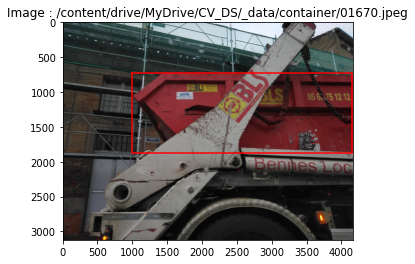

==== Après ====
(456, 456, 3)
tf.Tensor([0.38076922 0.41442308 0.75961536 0.3679487 ], shape=(4,), dtype=float32)
Coordonnées BB /content/drive/MyDrive/CV_DS/_data/container/01670.jpeg
x:173.6307656764984 y:188.97692370414734 w:346.3846049308777 h:167.7846121788025
x1:0.4384632110595703 x2:346.82306814193726 y1:105.0846176147461 y2:272.8692297935486


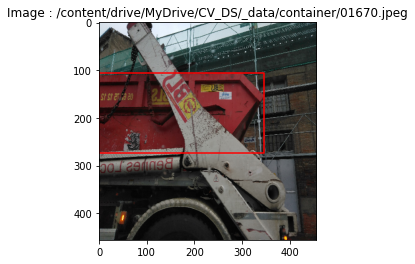

In [47]:
# ================================================================================================
# Définition de l'image pour test de la fonction de chargement d'image
i = random.choices(range(len(X_train)), k=1)[0]
img_path = X_train[i]

# ================================================================================================
# Test de la fonction
image = plt.imread(img_path)
y = y_train[i]
print("==== Avant ====")
print(image.shape)
print(y)
show_img_bb (image, y[0], y[1], y[2], y[3], img_path)
plt.show()

# Application de la fonction fonctions
image_new, y_new = magic_loader(img_path, y,
                                fromfile = True,
                                resize = (imgRsize[0], imgRsize[0]),
                                dataAugmentation = True)

print("==== Après ====")
print(image_new.shape)
print(y_new)
show_img_bb (image_new, y_new[0], y_new[1], y_new[2], y_new[3], img_path )
plt.show()

## Générateurs de données

In [48]:
AUTO = tf.data.experimental.AUTOTUNE

# Définition des paramètres
ratio = 0.5
batch_size = 32

# Génération d'un dataset tf à partir du set d'origine
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train)).map(lambda x, y : tf.py_function(magic_loader, [x,
                                                                                                    y,
                                                                                                    True,
                                                                                                    imgRsize,
                                                                                                    True],[tf.uint8, tf.float32]
                                                                                    ), num_parallel_calls=-1)\
                                                    .batch(int(batch_size),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# # Construction du générateur d'entrainement
# gen_train = generator(tf_dataset = dataset_train,
#                       noobj_img = background_image,
#                       batch_size = batch_size,
#                       ratio = ratio)

In [49]:
# Définition d'un générateur
def generator(dataset):
    iterator = iter(dataset)
    while True:
        X, y = next(iterator)
        yield X, y

# Définition du générateur d'entrainement.
train_generator = generator(dataset_train)

In [50]:
# Visualisation des sorties du générateur train

X_t, y_t = next(train_generator)

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0], bbox[1], bbox[2], bbox[3], "X" )
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [51]:
# Test
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(len(X_test)).map(lambda x, y : tf.py_function(magic_loader, [x,
                                                                                                    y,
                                                                                                    True,
                                                                                                    imgRsize,
                                                                                                    True],[tf.uint8, tf.float32]
                                                                                    ), num_parallel_calls=-1)\
                                                    .batch(int(batch_size),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)

# Définition du générateur de validation.
test_generator = generator(dataset_test)

In [52]:
# Visualisation des sorties du générateur test

X_t, y_t = next(test_generator)

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0], bbox[1], bbox[2], bbox[3], "X" )
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Modélisation

## Partrie encoder

In [53]:
from tensorflow.keras.applications import EfficientNetB5

# Load the model efficientNet
TL_model = EfficientNetB5(include_top=False, input_shape=(imgRsize[0],imgRsize[1],3))

# Freeze the blackbone
for layer in TL_model.layers:
    layer.trainable = False

## Partie régression

In [54]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(TL_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

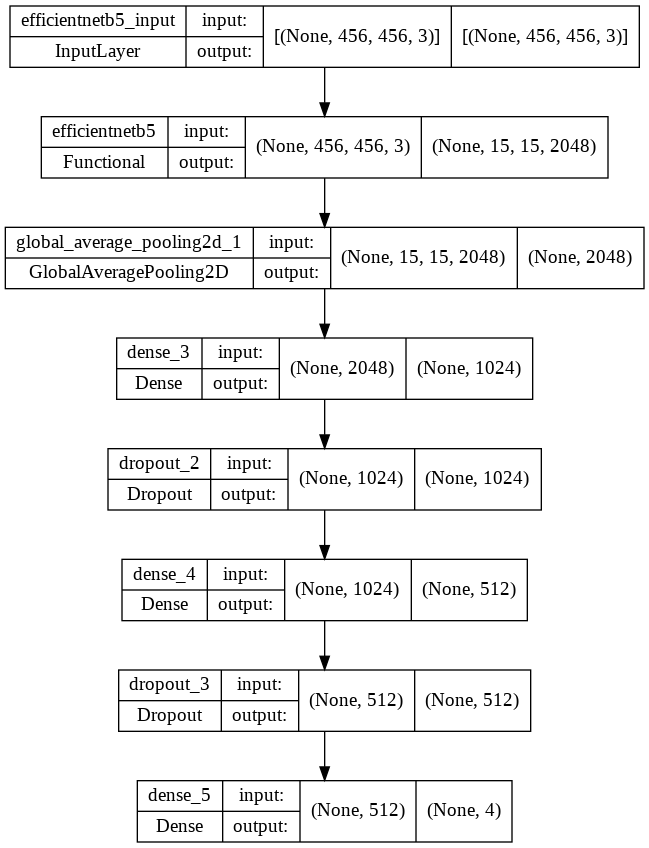

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Metrics

In [56]:
mse = tf.keras.metrics.MeanAbsoluteError()

## Fonction de perte

In [57]:
y_pred = model.predict(X_t)

In [58]:
def mae (y_true, y_pred):
    mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mae

In [59]:
# Coordinate loss for the prediction X_t
mae(y_t, y_pred)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.60423684, 0.78340185, 0.7362099 , 0.7224376 , 0.6522378 ,
       0.67504346, 0.6337872 , 0.5742506 , 0.67376995, 0.73697335,
       0.37218392, 0.62602246, 0.41976   , 0.8502556 , 0.696278  ,
       0.65735066, 0.6574295 , 0.728721  , 0.72143483, 0.7712147 ,
       0.6187204 , 0.58273244, 0.60163677, 0.6410916 , 0.62423855,
       0.63938546, 0.54592645, 0.5912728 , 0.74563044, 0.631075  ,
       0.5609033 , 0.5556836 ], dtype=float32)>

## Compilation

In [60]:
import tensorflow_addons as tfa

INIT_LR = 1e-4
MAX_LR = 1e-2

steps_per_epoch = len(X_train) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch
                                         )


In [61]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss=mae,
              optimizer=SGD(clr),
              metrics = [mse]
             )

## Callbacks

In [62]:
from tensorflow.keras import callbacks

In [63]:
# Réduction du lr sur un plateau
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         verbose=2,
                                         mode='min')

In [64]:
# Callback pour l'arrêt anticipé si les perfos ne s'améliorent pas.
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

## Entrainement

In [65]:
nb_epochs = 40
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping]
                   )

Epoch 1/40
15/15 [==============================] - 46s 2s/step - loss: 0.5658 - mean_absolute_error: 0.5658 - val_loss: 0.4057 - val_mean_absolute_error: 0.4057
Epoch 2/40
15/15 [==============================] - 8s 538ms/step - loss: 0.2820 - mean_absolute_error: 0.2820 - val_loss: 0.1702 - val_mean_absolute_error: 0.1702
Epoch 3/40
15/15 [==============================] - 8s 538ms/step - loss: 0.2162 - mean_absolute_error: 0.2162 - val_loss: 0.1575 - val_mean_absolute_error: 0.1575
Epoch 4/40
15/15 [==============================] - 8s 538ms/step - loss: 0.2058 - mean_absolute_error: 0.2058 - val_loss: 0.1536 - val_mean_absolute_error: 0.1536
Epoch 5/40
15/15 [==============================] - 8s 541ms/step - loss: 0.2051 - mean_absolute_error: 0.2051 - val_loss: 0.1517 - val_mean_absolute_error: 0.1517
Epoch 6/40
15/15 [==============================] - 8s 538ms/step - loss: 0.2057 - mean_absolute_error: 0.2057 - val_loss: 0.1448 - val_mean_absolute_error: 0.1448
Epoch 7/40
15/15 [

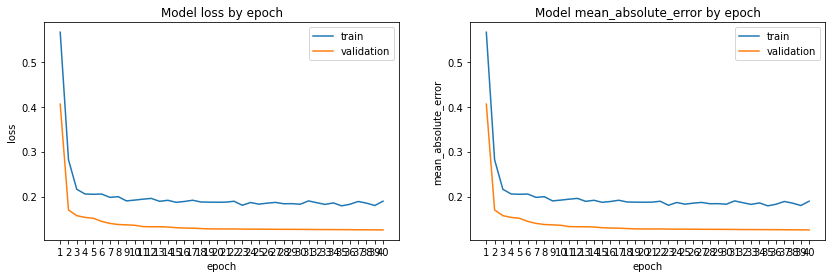

In [68]:
# Config
first_var = 'loss'
second_var = 'mean_absolute_error'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# # Config
# first_var = 'metric_confident'
# second_var = 'lr'
# history = history

# # Mise à l'échelle des nb d'epochs
# tick_locs = list(range(0,nb_epochs))
# tick_lbls = list(range(1,nb_epochs+1))

# plt.figure(figsize=(14,4))
# # Graphe var 1
# plt.subplot(121)
# plt.plot(history.history[first_var])
# plt.plot(history.history['val_'+first_var])
# plt.title(f'Model {first_var} by epoch')
# plt.ylabel(first_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.legend(['train', 'validation'], loc='best')

# # Graphe var 2
# plt.subplot(122)
# plt.plot(history.history[second_var])
# plt.title(f'Model {second_var} by epoch')
# plt.ylabel(second_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.show()

## Inférence

In [70]:
X_t, y_t = next(test_generator)

==== Image et BB source ====
Coordonnées BB X
x:228.0 y:314.8571376800537 w:456.0 h:282.2857246398926
x1:0.0 x2:456.0 y1:173.71427536010742 y2:456.0


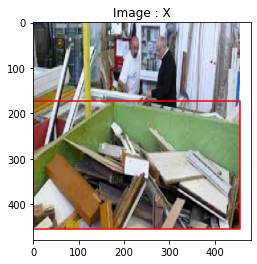

==== Image et BB après prédiction ====
Coordonnées BB X
x:168.53333187103271 y:186.49829649925232 w:262.683385848999 h:286.1199402809143
x1:37.1916389465332 x2:299.8750247955322 y1:43.438326358795166 y2:329.5582666397095


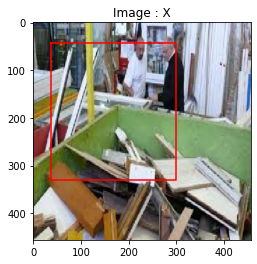

In [73]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_bb (img_ori, coord_ori[0], coord_ori[1], coord_ori[2], coord_ori[3], "X" )
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
x, y, w, h = model.predict(tf.expand_dims(X_t[i], axis=0))[0]
show_img_bb (img_ori, x, y, w, h, "X" )
plt.show()

In [74]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
    x, y, w, h = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_bb (img, x, y, w, h, "X" )
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Defreeze

In [75]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

input_2
======================== False
rescaling_1
======================== False
normalization_1
======================== False
stem_conv_pad
======================== False
stem_conv
======================== False
stem_bn
======================== False
stem_activation
======================== False
block1a_dwconv
======================== False
block1a_bn
======================== False
block1a_activation
======================== False
block1a_se_squeeze
======================== False
block1a_se_reshape
======================== False
block1a_se_reduce
======================== False
block1a_se_expand
======================== False
block1a_se_excite
======================== False
block1a_project_conv
======================== False
block1a_project_bn
======================== False
block1b_dwconv
======================== False
block1b_bn
======================== False
block1b_activation
======================== False
block1b_se_squeeze
======================== False
block1b_se_reshape
=====

In [76]:
plot_model(TL_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [77]:
# unfreeze the blackbone
for layer in TL_model.layers[-5:]:
    layer.trainable = True

In [78]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

input_2
======================== False
rescaling_1
======================== False
normalization_1
======================== False
stem_conv_pad
======================== False
stem_conv
======================== False
stem_bn
======================== False
stem_activation
======================== False
block1a_dwconv
======================== False
block1a_bn
======================== False
block1a_activation
======================== False
block1a_se_squeeze
======================== False
block1a_se_reshape
======================== False
block1a_se_reduce
======================== False
block1a_se_expand
======================== False
block1a_se_excite
======================== False
block1a_project_conv
======================== False
block1a_project_bn
======================== False
block1b_dwconv
======================== False
block1b_bn
======================== False
block1b_activation
======================== False
block1b_se_squeeze
======================== False
block1b_se_reshape
=====

# Entrainement

In [79]:
nb_epochs = 40
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping]
                   )

Epoch 1/40
15/15 [==============================] - 8s 557ms/step - loss: 0.1813 - mean_absolute_error: 0.1813 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257
Epoch 2/40
15/15 [==============================] - 8s 540ms/step - loss: 0.1873 - mean_absolute_error: 0.1873 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257
Epoch 3/40
15/15 [==============================] - 8s 539ms/step - loss: 0.1839 - mean_absolute_error: 0.1839 - val_loss: 0.1256 - val_mean_absolute_error: 0.1256
Epoch 4/40
15/15 [==============================] - 8s 538ms/step - loss: 0.1880 - mean_absolute_error: 0.1880 - val_loss: 0.1255 - val_mean_absolute_error: 0.1255
Epoch 5/40
15/15 [==============================] - 8s 539ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.1255 - val_mean_absolute_error: 0.1255
Epoch 6/40
15/15 [==============================] - 8s 539ms/step - loss: 0.1816 - mean_absolute_error: 0.1816 - val_loss: 0.1253 - val_mean_absolute_error: 0.1253
Epoch 7/40
15/15

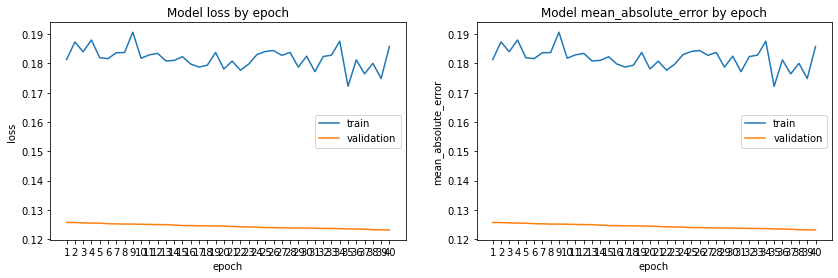

In [80]:
# Config
first_var = 'loss'
second_var = 'mean_absolute_error'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# # Config
# first_var = 'metric_confident'
# second_var = 'lr'
# history = history

# # Mise à l'échelle des nb d'epochs
# tick_locs = list(range(0,nb_epochs))
# tick_lbls = list(range(1,nb_epochs+1))

# plt.figure(figsize=(14,4))
# # Graphe var 1
# plt.subplot(121)
# plt.plot(history.history[first_var])
# plt.plot(history.history['val_'+first_var])
# plt.title(f'Model {first_var} by epoch')
# plt.ylabel(first_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.legend(['train', 'validation'], loc='best')

# # Graphe var 2
# plt.subplot(122)
# plt.plot(history.history[second_var])
# plt.title(f'Model {second_var} by epoch')
# plt.ylabel(second_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.show()

## Inférence

==== Image et BB source ====
Coordonnées BB X
x:228.0 y:314.8571376800537 w:456.0 h:282.2857246398926
x1:0.0 x2:456.0 y1:173.71427536010742 y2:456.0


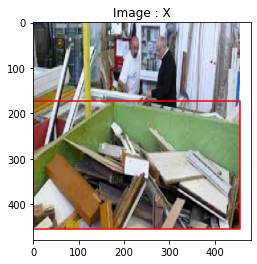

==== Image et BB après prédiction ====
Coordonnées BB X
x:172.9278438091278 y:191.90529370307922 w:271.322078704834 h:293.70656061172485
x1:37.266804456710815 x2:308.5888831615448 y1:45.0520133972168 y2:338.75857400894165


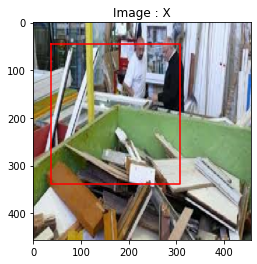

In [83]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_bb (img_ori, coord_ori[0], coord_ori[1], coord_ori[2], coord_ori[3], "X" )
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
x, y, w, h = model.predict(tf.expand_dims(X_t[i], axis=0))[0]
show_img_bb (img_ori, x, y, w, h, "X" )
plt.show()

In [84]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
    x, y, w, h = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_bb (img, x, y, w, h, "X" )
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Conclusion

On observe toujours des images avec des containers en gros plan. Cela est préjudiciable à notre objectif final de positionner des keypoints pour avoir une structure 3 d. Il faudra certainement épurer encore le dataset.

# Bac à sable

In [ ]:
# # Fonction d'exploration de l'arborescence des json
# def json_tree (file):
#     tree_str = json.dumps(file, indent=4)
#     tree_str = tree_str.replace("\n    ", "\n").replace('"', "").replace(',', "").replace("{", "")
#     tree_str = tree_str.replace("}", "").replace("    ", " | ").replace("  ", " ")
#     return print(tree_str)

In [ ]:
# "W:/CV/gtBbox3d/train/aachen/aachen_000000_000019_gtBbox3d.json"

In [ ]:
# path = "W:/CV/gtBbox3d/train/aachen/aachen_000000_000019_gtBbox3d.json"

# # Ouverture du fichier json
# with open(path, 'r') as f:
#     data = json.load(f)

In [ ]:
# json_tree (data)

In [ ]:
# import os
# dir_list = os.listdir("W:/CV/gtBbox3d/train")

In [ ]:
# df = pd.DataFrame()

# column_names = ["town", "b", "c"]

# df = pd.DataFrame(columns = column_names)

In [ ]:
# for i in dir_list:
#     print(i)
#     df["town"]
    